# Ground-Cover Classification Activity

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from osgeo import gdal

## Data

We're going to be looking at satellite images. Let's have a look at one.

In [78]:
satellite_2004_full = gdal.Open('../img/SPOT/2004.img').ReadAsArray() / 255
satellite_2010_full = gdal.Open('../img/SPOT/2010.img').ReadAsArray() / 255

In [125]:
scale_by = .25
import scipy.misc
def scale_image(img, size):
    return np.array([scipy.misc.imresize(chan, size) for chan in img])
satellite_2004 = scale_image(satellite_2004_full, scale_by)
satellite_2010 = scale_image(satellite_2010_full, scale_by) 

In [133]:
rows, cols = satellite_2010.shape[1:]
assert rows, cols == satellite_2004.shape[1:]

In [85]:
def show_image(img, ax=None):
    if len(img.shape) == 3:
        img = np.transpose(img, (1,2,0))
    if ax is None:
        plt.imshow(img)
    else:
        ax.imshow(img)

def show_rgb(red, green, blue, ax=None):
    show_image(np.array([red, green, blue]), ax=ax)

<IPython.core.display.Javascript object>


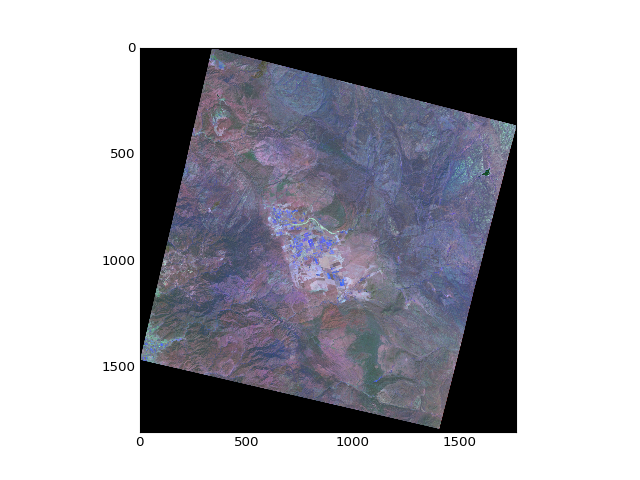

In [87]:
fig, axes = plt.subplots()
green, red, NIR, MIR = satellite_2010
show_rgb(red=MIR, green=NIR, blue=green)
#show_rgb(red=red, green=green, blue=green)

Exercises here TODO:
1. exploring how an image is represented, as pixels
2. trying different ways of mapping the spectral channels

# Define the Problem

We're going to try to identify ground cover.

* Input: a satellite image (4 channels: red, green, NIR, MIR)
* Output: which class we think each pixel is in

What makes a *good* output? We'll use a simple measure for now: how many pixels did we get right?

In [126]:
classes_2004 = scipy.misc.imresize(gdal.Open("../img/SPOT/2004_12class.img").ReadAsArray(), scale_by)
classes_2010 = scipy.misc.imresize(gdal.Open("../img/SPOT/2010_12class.img").ReadAsArray(), scale_by)

In [143]:
# This is if we we wanted to cluster ourselves:
import sklearn.cluster
cluster = sklearn.cluster.MiniBatchKMeans(n_clusters=36)
np.reshape(satellite_2010, (4, -1)).shape
clustered_2010 = cluster.fit_predict(np.reshape(satellite_2010, (4, -1)).T).reshape(satellite_2010.shape[1:])
true_stream_idx = np.argmax(np.bincount(clustered_2010[838:850, 848:857].ravel()))

/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 3180565 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 3180565 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 3180565 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 3180565 + 1) instead
  0, n_samples - 1, init_size)
/Users/kcarnold/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randin

In [139]:
def show_img_and_classes(red, green, blue, classes, true_classes):
    fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(13,5))
    show_rgb(red=red, green=green, blue=blue, ax=axs[0])
    axs[1].imshow(classes)
    axs[2].imshow(classes == true_classes)

In [144]:
# Class 0: unknown
# Class 1: stream
true_classes_one_hot = np.zeros((2, rows, cols), dtype=bool)
true_classes_one_hot[1] = clustered_2010 == true_stream_idx
true_classes_one_hot[0] = true_classes_one_hot[1:].sum(axis=0) == 0
true_classes = np.argmax(true_classes_one_hot, axis=0)

In [147]:
def rectify(x): return np.maximum(x, 0)

<IPython.core.display.Javascript object>


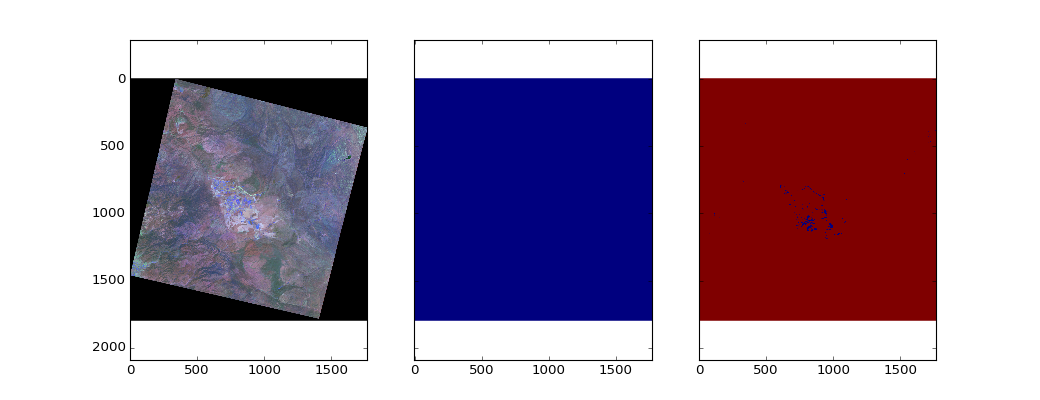

Accuracy: 0.99691344245


In [152]:
class_scores = np.ones((2, rows, cols))
class_scores[1] = 0
# class_scores[1] = rectify(2*green + 1.1*red + .5*MIR - 250)
guessed_classes = np.argmax(class_scores, axis=0)
show_img_and_classes(red=MIR, green=NIR, blue=green, classes=guessed_classes, true_classes=true_classes)
print("Accuracy:", np.sum(guessed_classes == true_classes) / (rows * cols))